In [1]:
import sys
import torch
from matplotlib import pyplot as plt
import numpy as np

folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

folder_path = '../data/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from pemp import PEMP

from data_generators import *
from positional_encoders import generate_positional_encoding
from plotters import *


torch.set_float32_matmul_precision('high')

def get_free_gpu():
    gpu_util = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch GPU
#        gpu_util.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
        gpu_util.append((i, torch.cuda.utilization()))
    gpu_util.sort(key=lambda x: x[1])
    return gpu_util[0][0]

if torch.cuda.is_available():
    available_gpu = get_free_gpu()
    if available_gpu == 0:
        device = torch.device("cuda:0")
    else:
        device = torch.device(f"cuda:{available_gpu}")
else:
    device = torch.device("cpu")
    
print("Device :", device)

Device : cuda:0


In [2]:
dx, dy = 1, 1
num_demos, num_val = 16, 4
num_trajs = num_demos + num_val
t_steps = 200
n_max, m_max = 20, 20
num_peaks = 3

dpe, dpe1, dpe2, dpe3 = 2,5,10,20

# x, y, pp = n_peaks(1, num_trajs, 0.1)
x, y, pp = n_peaks(num_peaks, num_trajs, 0.04)

val_ids = []
while len(val_ids) < num_val:
    val_id = np.random.choice(np.arange(num_trajs), 1)
    # continue if pp[val_id] is either smallest or largest value
    # append to val_id otherwise
    if (pp[val_id, 0] == torch.max(pp[:, 0]) or pp[val_id, 0] == torch.min(pp[:, 0])):
        continue
    else:
        if val_id not in val_ids:
            val_ids.append(val_id)

train_ids = np.setdiff1d(np.arange(num_trajs), val_ids)
val_ids = torch.tensor(val_ids).squeeze(-1)
train_ids = torch.from_numpy(train_ids)

test_cond_ind = (pp[val_ids] * 200).int()

y_train = y[train_ids].clone()
y_val = y[val_ids].clone()

x_train = x[train_ids].clone()
x_val = x[val_ids].clone()

# Print shapes
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")

x_train shape: torch.Size([16, 200, 1]), y_train shape: torch.Size([16, 200, 1])
x_val shape: torch.Size([4, 200, 1]), y_val shape: torch.Size([4, 200, 1])


/tmp/ipykernel_202016/3100645270.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  val_ids = torch.tensor(val_ids).squeeze(-1)


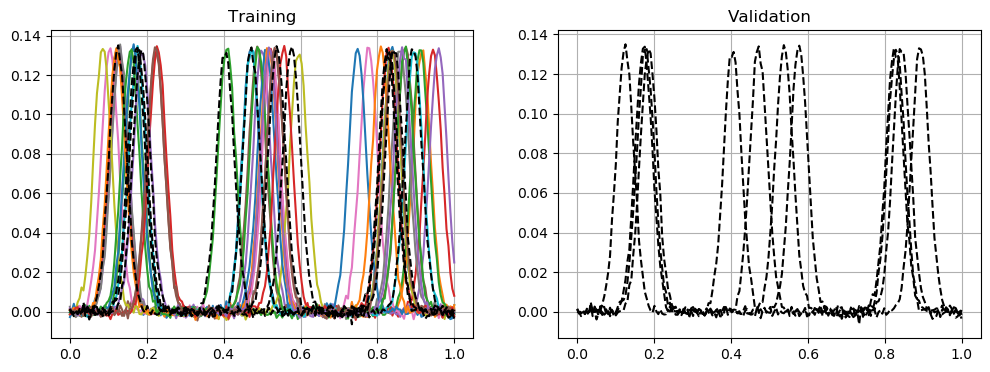

In [3]:
plot_train_val(num_demos, x_train, y_train, num_val, x_val, y_val)

In [4]:
batch_size = 4

num_models = 4

enc_dims = [128,128]
dec_dims = [128,128]

pemp_ = PEMP(input_dim=dpe, output_dim=dy, n_max=n_max, m_max=m_max, encoder_hidden_dims=enc_dims, decoder_hidden_dims=dec_dims, batch_size=batch_size, device=device)
optimizer = torch.optim.Adam(lr=3e-4, params=pemp_.parameters())

pemp_1 = PEMP(input_dim=dpe1, output_dim=dy, n_max=n_max, m_max=m_max, encoder_hidden_dims=enc_dims, decoder_hidden_dims=dec_dims, batch_size=batch_size, device=device)
optimizer1 = torch.optim.Adam(lr=3e-4, params=pemp_1.parameters())

pemp_2 = PEMP(input_dim=dpe2, output_dim=dy, n_max=n_max, m_max=m_max, encoder_hidden_dims=enc_dims, decoder_hidden_dims=dec_dims, batch_size=batch_size, device=device)
optimizer2 = torch.optim.Adam(lr=3e-4, params=pemp_2.parameters())

pemp_3 = PEMP(input_dim=dpe3, output_dim=dy, n_max=n_max, m_max=m_max, encoder_hidden_dims=enc_dims, decoder_hidden_dims=dec_dims, batch_size=batch_size, device=device)
optimizer3 = torch.optim.Adam(lr=3e-4, params=pemp_3.parameters())


if torch.__version__ >= "2.0":
    pemp, pemp1, pemp2, pemp3 = torch.compile(pemp_), torch.compile(pemp_1), torch.compile(pemp_2), torch.compile(pemp_3)
else:
    pemp, pemp1, pemp2, pemp3 = pemp_, pemp_1, pemp_2, pemp_3

In [7]:
pe = []  # keeping pe's for each model with different frequencies
pe.append(generate_positional_encoding(d_model=dpe) / dpe)  # /dpe since dpe-many pes and only one SM
pe.append(generate_positional_encoding(d_model=dpe1) / dpe1)
pe.append(generate_positional_encoding(d_model=dpe2) / dpe2)
pe.append(generate_positional_encoding(d_model=dpe3) / dpe3)

In [8]:
for i in range(4):
    print(pe[i].shape)

torch.Size([200, 2])
torch.Size([200, 5])
torch.Size([200, 10])
torch.Size([200, 20])


In [6]:
obs = torch.zeros((batch_size, n_max, dpe+dy), dtype=torch.float32, device=device)
tar_x = torch.zeros((batch_size, m_max, dpe), dtype=torch.float32, device=device)

obs1 = torch.zeros((batch_size, n_max, dpe1+dy), dtype=torch.float32, device=device)
tar_x1 = torch.zeros((batch_size, m_max, dpe1), dtype=torch.float32, device=device)

obs2 = torch.zeros((batch_size, n_max, dpe2+dy), dtype=torch.float32, device=device)
tar_x2 = torch.zeros((batch_size, m_max, dpe2), dtype=torch.float32, device=device)

obs3 = torch.zeros((batch_size, n_max, dpe3+dy), dtype=torch.float32, device=device)
tar_x3 = torch.zeros((batch_size, m_max, dpe3), dtype=torch.float32, device=device)

tar_y = torch.zeros((batch_size, m_max, dy), dtype=torch.float32, device=device)
obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
tar_mask = torch.zeros((batch_size, m_max), dtype=torch.bool, device=device)

def prepare_masked_batch(t: list, traj_ids: list):
    obs.fill_(0)
    tar_x.fill_(0)
    tar_y.fill_(0)
    obs_mask.fill_(False)
    tar_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(1, n_max+1, (1,)).item()
        m = torch.randint(1, m_max+1, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = permuted_ids[n:n+m]

        obs_mask[i, :n] = True
        obs[i, :n, :dpe] = pe[0][n_ids] # PE(t)
        obs[i, :n, dpe:] = traj[n_ids]  # SM(t)
        tar_x[i, :m, :dpe] = pe[0][m_ids]

        obs1[i, :n, :dpe1] = pe[1][n_ids] # PE(t)
        obs1[i, :n, dpe1:] = traj[n_ids]  # SM(t)
        tar_x1[i, :m, :dpe1] = pe[1][m_ids]

        obs2[i, :n, :dpe2] = pe[2][n_ids] # PE(t)
        obs2[i, :n, dpe2:] = traj[n_ids]  # SM(t)
        tar_x2[i, :m, :dpe2] = pe[2][m_ids]

        obs3[i, :n, :dpe3] = pe[3][n_ids] # PE(t)
        obs3[i, :n, dpe3:] = traj[n_ids]  # SM(t)
        tar_x3[i, :m, :dpe3] = pe[3][m_ids]

        tar_y[i, :m] = traj[m_ids]
        tar_mask[i, :m] = True

val_obs = torch.zeros((batch_size, n_max, dpe+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dpe), dtype=torch.float32, device=device)

val_obs1 = torch.zeros((batch_size, n_max, dpe1+dy), dtype=torch.float32, device=device)
val_tar_x1 = torch.zeros((batch_size, t_steps, dpe1), dtype=torch.float32, device=device)

val_obs2 = torch.zeros((batch_size, n_max, dpe2+dy), dtype=torch.float32, device=device)
val_tar_x2 = torch.zeros((batch_size, t_steps, dpe2), dtype=torch.float32, device=device)

val_obs3 = torch.zeros((batch_size, n_max, dpe3+dy), dtype=torch.float32, device=device)
val_tar_x3 = torch.zeros((batch_size, t_steps, dpe3), dtype=torch.float32, device=device)

val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

def prepare_masked_val_batch(t: list, traj_ids: list, fixed_ind=None):
    val_obs.fill_(0)
    val_tar_x.fill_(0)
    val_tar_y.fill_(0)
    val_obs_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = num_peaks #torch.randint(5, n_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = torch.zeros(n, dtype=torch.long)

        if fixed_ind != None:
            for p in range(n):
                n_ids[p] = fixed_ind[i, p]
        else:
            n_ids = permuted_ids[:n]

        m_ids = torch.arange(t_steps)  # all time steps for full trajectory generation

        val_obs_mask[i, :n] = True
        
        val_obs[i, :n, :dpe] = pe[0][n_ids]
        val_obs[i, :n, dpe:] = traj[n_ids]
        val_tar_x[i, :, :dpe] = pe[0]

        val_obs1[i, :n, :dpe1] = pe[1][n_ids]
        val_obs1[i, :n, dpe1:] = traj[n_ids]
        val_tar_x1[i, :, :dpe1] = pe[1]

        val_obs2[i, :n, :dpe2] = pe[2][n_ids]
        val_obs2[i, :n, dpe2:] = traj[n_ids]
        val_tar_x2[i, :, :dpe2] = pe[2]

        val_obs3[i, :n, :dpe3] = pe[3][n_ids]
        val_obs3[i, :n, dpe3:] = traj[n_ids]
        val_tar_x3[i, :, :dpe3] = pe[3]

        val_tar_y[i] = traj[m_ids]

In [8]:
import time
import os

pose_code = 'no_pos'
arch_code = str(num_demos) + '_' + str(num_val) + '_'
for i in enc_dims:
    arch_code += str(i) + '_'
arch_code = arch_code[:-1]

pes_code = f'{dpe}_{dpe1}_{dpe2}_{dpe3}'

timestamp = int(time.time())
root_folder = f'../outputs/ablation/{num_peaks}_peak/{pose_code}/{arch_code}/{pes_code}/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

img_folder = f'{root_folder}img/'
if not os.path.exists(img_folder):
    os.makedirs(img_folder)

torch.save(y_train, f'{root_folder}y.pt')

epochs = 250_000
epoch_iter = num_demos // batch_size
v_epoch_iter = num_val//batch_size
avg_loss, avg_loss1, avg_loss2, avg_loss3 = 0, 0, 0, 0
loss_report_interval = 500
val_per_epoch = 1000
min_val_loss, min_val_loss1, min_val_loss2, min_val_loss3 = 1000000, 1000000, 1000000, 1000000
mse_loss = torch.nn.MSELoss()

plot_validation = True

l, l1, l2, l3 = [], [], [], []

for epoch in range(epochs):
    epoch_loss, epoch_loss1, epoch_loss2, epoch_loss3 = 0, 0, 0, 0

    traj_ids = torch.randperm(num_demos)[:batch_size * epoch_iter].chunk(epoch_iter)

    for i in range(epoch_iter):
        prepare_masked_batch(y_train, traj_ids[i])

        optimizer.zero_grad()        
        pred = pemp(obs[0], tar_x[0], obs_mask)
        loss = pemp.loss(pred, tar_y, tar_mask)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        optimizer1.zero_grad()        
        pred = pemp1(obs[1], tar_x[1], obs_mask)
        loss = pemp1.loss(pred, tar_y, tar_mask)
        loss.backward()
        optimizer1.step()

        epoch_loss1 += loss.item()

        optimizer2.zero_grad()        
        pred = pemp2(obs[2], tar_x[2], obs_mask)
        loss = pemp2.loss(pred, tar_y, tar_mask)
        loss.backward()
        optimizer2.step()

        epoch_loss2 += loss.item()

        optimizer3.zero_grad()        
        pred = pemp3(obs[3], tar_x[3], obs_mask)
        loss = pemp3.loss(pred, tar_y, tar_mask)
        loss.backward()
        optimizer3.step()

        epoch_loss3 += loss.item()


    if epoch % val_per_epoch == 0 and epoch > 0:
        with torch.no_grad():
            v_traj_ids = torch.randperm(num_val)[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
            val_loss, val_loss1, val_loss2, val_loss3 = 0, 0, 0, 0

            for j in range(v_epoch_iter):
                prepare_masked_val_batch(y_val, v_traj_ids[j], test_cond_ind[v_traj_ids[j]])

                pred = pemp.val(val_obs[0], val_tar_x[0], val_obs_mask)
                if plot_validation:
                    for k in range(batch_size):
                        plt.plot(val_tar_y[k, :, 0].cpu().numpy(), label=f"True {k}")
                        plt.plot(pred[k, :, 0].cpu().numpy(), label=f"Pred {k}")
                        
                        plt.legend()
                        plt.savefig(f'{img_folder}{epoch}_PEMP0_{j}_{k}.png')
                        plt.clf()
                val_loss += mse_loss(pred[:, :, :pemp.output_dim], val_tar_y).item()

                pred = pemp1.val(val_obs[1], val_tar_x[1], val_obs_mask)
                if plot_validation:
                    for k in range(batch_size):
                        plt.plot(val_tar_y[k, :, 0].cpu().numpy(), label=f"True {k}")
                        plt.plot(pred[k, :, 0].cpu().numpy(), label=f"Pred {k}")
                        
                        plt.legend()
                        plt.savefig(f'{img_folder}{epoch}_PEMP1_{j}_{k}.png')
                        plt.clf()
                val_loss1 += mse_loss(pred[:, :, :pemp1.output_dim], val_tar_y).item()

                pred = pemp2.val(val_obs[2], val_tar_x[2], val_obs_mask)
                if plot_validation:
                    for k in range(batch_size):
                        plt.plot(val_tar_y[k, :, 0].cpu().numpy(), label=f"True {k}")
                        plt.plot(pred[k, :, 0].cpu().numpy(), label=f"Pred {k}")
                        
                        plt.legend()
                        plt.savefig(f'{img_folder}{epoch}_PEMP2_{j}_{k}.png')
                        plt.clf()
                val_loss2 += mse_loss(pred[:, :, :pemp2.output_dim], val_tar_y).item()

                pred = pemp3.val(val_obs[3], val_tar_x[3], val_obs_mask)
                if plot_validation:
                    for k in range(batch_size):
                        plt.plot(val_tar_y[k, :, 0].cpu().numpy(), label=f"True {k}")
                        plt.plot(pred[k, :, 0].cpu().numpy(), label=f"Pred {k}")
                        
                        plt.legend()
                        plt.savefig(f'{img_folder}{epoch}_PEMP3_{j}_{k}.png')
                        plt.clf()
                val_loss3 += mse_loss(pred[:, :, :pemp3.output_dim], val_tar_y).item()


            
            val_loss /= v_epoch_iter
            val_loss1 /= v_epoch_iter
            val_loss2 /= v_epoch_iter
            val_loss3 /= v_epoch_iter

            if val_loss < min_val_loss:
                min_val_loss = val_loss
                print(f'PEMP0 New best: {min_val_loss}', f'P1 best: {min_val_loss1}, P2 best: {min_val_loss2}, P3 best: {min_val_loss3}')
                torch.save(pemp_.state_dict(), f'{root_folder}saved_models/pemp0.pt')
            
            if val_loss1 < min_val_loss1:
                min_val_loss1 = val_loss1
                print(f'PEMP1 New best: {min_val_loss1}', f'P0 best: {min_val_loss}, P2 best: {min_val_loss2}, P3 best: {min_val_loss3}')
                torch.save(pemp_1.state_dict(), f'{root_folder}saved_models/pemp1.pt')

            if val_loss2 < min_val_loss2:
                min_val_loss2 = val_loss2
                print(f'PEMP2 New best: {min_val_loss2}', f'P0 best: {min_val_loss}, P1 best: {min_val_loss1}, P3 best: {min_val_loss3}')
                torch.save(pemp_2.state_dict(), f'{root_folder}saved_models/pemp2.pt')

            if val_loss3 < min_val_loss3:
                min_val_loss3 = val_loss3
                print(f'PEMP3 New best: {min_val_loss3}', f'P0 best: {min_val_loss}, P1 best: {min_val_loss1}, P2 best: {min_val_loss2}')
                torch.save(pemp_3.state_dict(), f'{root_folder}saved_models/pemp3.pt')

    epoch_loss /= epoch_iter
    epoch_loss1 /= epoch_iter
    epoch_loss2 /= epoch_iter
    epoch_loss3 /= epoch_iter

    avg_loss += epoch_loss
    avg_loss1 += epoch_loss1
    avg_loss2 += epoch_loss2
    avg_loss3 += epoch_loss3

    l.append(epoch_loss)
    l1.append(epoch_loss1)
    l2.append(epoch_loss2)
    l3.append(epoch_loss3)

    if epoch % loss_report_interval == 0:
        print("Epoch: {}, P0 Loss: {}, P1 Loss: {}, P2 Loss: {}, P3 Loss: {}".format(epoch, avg_loss/loss_report_interval, avg_loss1/loss_report_interval, avg_loss2/loss_report_interval, avg_loss3/loss_report_interval))
        avg_loss, avg_loss1, avg_loss2, avg_loss3 = 0, 0, 0, 0

Epoch: 0, P0 Loss: 0.0009350391328334808, P1 Loss: 0.0010113371312618256, P2 Loss: 0.0009813752621412278, P3 Loss: 0.001128876805305481
Epoch: 500, P0 Loss: -1.623701612926874, P1 Loss: -1.63496147278836, P2 Loss: -1.6576813089228235, P3 Loss: -1.6253244073819368
PEMP0 New best: 0.0016632401384413242 P1 best: 1000000, P2 best: 1000000, P3 best: 1000000
PEMP1 New best: 0.0016507168766111135 P0 best: 0.0016632401384413242, P2 best: 1000000, P3 best: 1000000
PEMP2 New best: 0.0016720063285902143 P0 best: 0.0016632401384413242, P1 best: 0.0016507168766111135, P3 best: 1000000
PEMP3 New best: 0.0016544824466109276 P0 best: 0.0016632401384413242, P1 best: 0.0016507168766111135, P2 best: 0.0016720063285902143
Epoch: 1000, P0 Loss: -1.7437046902179718, P1 Loss: -1.7492494599223136, P2 Loss: -1.7492484591007234, P3 Loss: -1.7457989535927771
Epoch: 1500, P0 Loss: -1.749111825287342, P1 Loss: -1.752596333563328, P2 Loss: -1.750996757030487, P3 Loss: -1.7525646214485169
PEMP0 New best: 0.001631048

In [ ]:
torch.save(l, f'{root_folder}losses.pt')
torch.save(l1, f'{root_folder}losses1.pt')
torch.save(l2, f'{root_folder}losses2.pt')
torch.save(l3, f'{root_folder}losses3.pt')